# Linear regression

## 1) Without uncertainties

In [78]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.odr.odrpack as odrpack

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

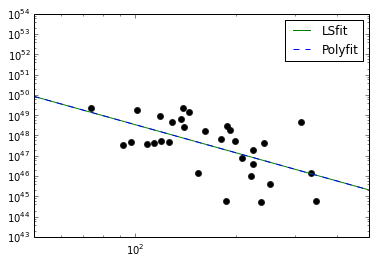

In [79]:
def least_sq(x,y):
    
    sxx = np.sum((x-np.mean(x))**2)
    syy = np.sum((y-np.mean(y))**2)
    sxy = np.sum((x-np.mean(x))*(y-np.mean(y)))
    
    beta = sxy/sxx
    beta_var = np.sum((x-np.mean(x))**2*((y-np.mean(y))-beta*(x-np.mean(x)))**2)/sxx**2
    
    alpha = np.mean(y)-beta*np.mean(x)
    
    return(alpha,beta,beta_var)

data = np.loadtxt('data/Ampl_Lum.dat',comments='#')
x = data[:,0]
y = data[:,1]

alpha, beta, bvar = least_sq(np.log10(x),np.log10(y))

xx = np.linspace(10,1000,50)
yy = map(lambda m: 10**(beta * m + alpha), np.log10(xx))

# Alternatively we use an internal function of np
line = np.polyfit(np.log10(x),np.log10(y),1)
yy2 = map(lambda m: 10**(line[0] * m + line[1]), np.log10(xx))

fig1 = plt.subplot(111)
plt.errorbar(x,y,xerr=0,yerr=0,color='k', marker='o',linestyle='None')
fig1.set_xscale('log')
fig1.set_yscale('log')
plt.xlim(50,500)
plt.plot(xx,yy,c='g',label='LSfit')
plt.plot(xx,yy2,c='b',ls='--',label='Polyfit')
plt.legend()
plt.show()


The two lines are exactly the same.

## 2) With uncertainties
In this case we will use ODR (orthogonal distance regression with weights) to get the weighted fitting and compare it with the linear one. (We suppose that x has a homoscedastic error of 10% and y of 12%).

In [80]:
data_new = odrpack.RealData(x, y, sx=0.1*x, sy=0.12*y)

def f(B, x):
    return B[0]*x + B[1]

model = odrpack.Model(f)
myodr = odrpack.ODR(data_new, model,[0, 1])
myoutput = myodr.run()
myoutput.pprint()

yy3 = f(myoutput.beta,xx)

Beta: [6.03405211e+40 6.13429577e+44]
Beta Std Error: [5.01741027e+42 1.30841452e+45]
Beta Covariance: [[ 3.84030821e+83 -9.70868305e+85]
 [-9.70868305e+85  2.61154528e+88]]
Residual Variance: 65.553087068
Inverse Condition #: 0.00914947910147
Reason(s) for Halting:
  Sum of squares convergence


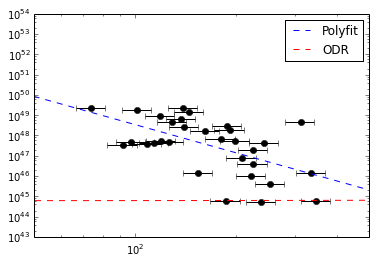

In [81]:
fig1 = plt.subplot(111)
plt.errorbar(x,y,xerr=x*0.1,yerr=0.12*y,color='k', marker='o',linestyle='None')
fig1.set_xscale('log')
fig1.set_yscale('log')
plt.xlim(50,500)
plt.plot(xx,yy2,c='b',ls='--',label='Polyfit')
plt.plot(xx,yy3,c='r',ls='--',label='ODR')
plt.legend()
plt.show()


...it didn't work (check odr fitting)

## 3) Non-parametric regression

In [82]:
# Importanting libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.nonparametric.kernel_regression
%matplotlib inline

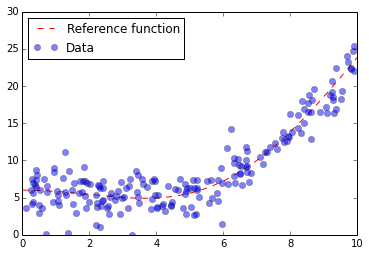

KernelReg instance
Number of variables: k_vars = 1
Number of samples:   N = 200
Variable types:      u
BW selection method: cv_ls
Estimator type: ll



In [83]:
# Create a random sample obeying to some sinusoidal function
def f(x):
    return 3*np.cos(x/2)+x**2/5+3

xs = np.random.rand(200)*10
ys = f(xs) + 2*np.random.randn(*xs.shape)

grid = np.r_[0:10:1000j] # from 0-10 in 1000 slices
plt.plot(grid, f(grid), 'r--', label='Reference function')
plt.plot(xs, ys, 'o', alpha=0.5, label='Data')
plt.legend(loc='best')
plt.show()

print statsmodels.nonparametric.kernel_regression.KernelReg(ys,xs,'u')

Now we have to fit it.

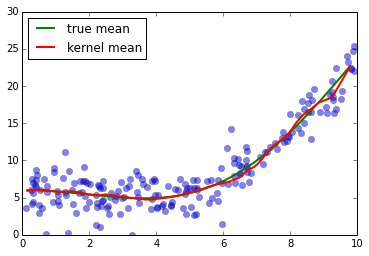

In [105]:
nobs = 100
x = np.random.uniform(0, 10, size=nobs)
x.sort()
x=np.array(x)

y_true=f(x) # real function

sigma=0.1
y=[np.random.normal(nn,sigma*nn) for nn in y_true]

model = statsmodels.nonparametric.kernel_regression.KernelReg(endog=[y],exog=[x], 
                                        reg_type='lc',var_type='c', bw='cv_ls')

sm_bw = model.bw
sm_mean, sm_mfx = model.fit()

# print (np.mean(y_true))
# print (np.mean(ys))
# print(np.mean(sm_mean))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(xs, ys, 'o', alpha=0.5)
ax.plot(x, y_true, lw=2, label='true mean')
ax.plot(x, sm_mean, lw=2, label='kernel mean')
ax.legend(loc='best')

plt.show()

## 4) Machine Learning linear regression

Estimated coefficients (true, normal, RANSAC):
(array(82.19039084), array([64.84380637]), array([82.01506455]))


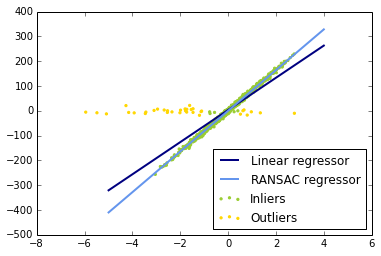

In [106]:
from sklearn import linear_model, datasets

n_samples = 1000
n_outliers = 40

# make_regression: generates a random regression problem
X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=5,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(10)
X[:n_outliers] = -2 + 2 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)

# Robustly fit linear model with RANSAC algorithm (its good for outliers)
model_ransac = linear_model.RANSACRegressor()
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(-5, 5)
line_y = model.predict(line_X[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print(coef, model.coef_, model_ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=lw,
         label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='-',
         linewidth=lw, label='RANSAC regressor')
plt.legend(loc='lower right')
plt.show()

We can see that although the linear regressor fails to remove alone the outliers the RANSAC algorithm does it (if we remove the outlier both methods give the same result). See more here: http://scikit-learn.org/stable/modules/linear_model.html#ransac-regression